# Import libraries

In [ ]:
!pip install split-folders
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-_rmymi78
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-_rmymi78
  Resolved https://github.com/tensorflow/docs to commit 60abeb06e500fa5edbbac374fc0d8142c8322aef
  Preparing metadata (setup.py) ... done


In [ ]:
# import requirement libraries and tools
import os
import pathlib
import itertools
import splitfolders
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# To enable dynamic memory allocation, run the following commands
# at the start of the session :
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Import Dataset

In [ ]:
!unzip archive.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_path = '/content/Rice_Image_Dataset'
root_path = pathlib.Path(root_path)

# Prepare dataset



In [ ]:
splitfolders.ratio(input=root_path, output='content/rice_imgs', seed=42, ratio=(0.7, 0.15, 0.15))

Copying files: 75000 files [44:48, 27.89 files/s]


In [ ]:
BATCH_SIZE = 16
# resize the images from the directories to prevent ResourceExhaustedError
IMAGE_SIZE = (150, 150)

Train = keras.utils.image_dataset_from_directory(
    directory='/content/rice_imgs/train',
    labels='inferred',
    label_mode='int',
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    seed=42,
)

Validation = keras.utils.image_dataset_from_directory(
    directory='/content/rice_imgs/val',
    labels='inferred',
    label_mode='int',
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    seed=42,
)

Test = keras.utils.image_dataset_from_directory(
    directory='/content/rice_imgs/test',
    labels='inferred',
    label_mode='int',
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    seed=42,
)

Found 52500 files belonging to 5 classes.
Found 11250 files belonging to 5 classes.
Found 11250 files belonging to 5 classes.


# Model 5

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam

def compile_and_fit(model, optimizer=None, max_epochs=2):
    """
    Compile model and fit model on dataset based on input model until find best epoch
        model: created model
        optimizer: defined optimizer
        max_epochs: Number of epochs
    """

    if optimizer is None:
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    # complie model before train
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    # train model
    history = model.fit(
        Train,
        epochs=max_epochs,
        validation_data=Validation,
        callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss' , patience=8),
    )

    return history

In [ ]:
model_5 = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=100, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dense(units=100, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=5),
    ]
)

model_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 87616)             0         
                                                                 
 dense (Dense)               (None, 100)               8761700   
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                        

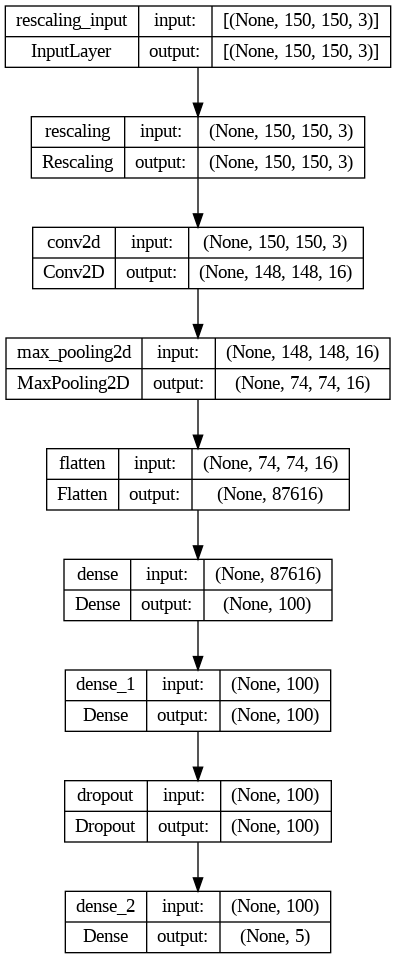

In [ ]:
keras.utils.plot_model(model_5, to_file='model_base.png', show_shapes=True,show_layer_names=True)

In [ ]:
# train model_3 and store results
model_hist = compile_and_fit(model_5, max_epochs=6)

Epoch 1/6
3282/3282 [==============================] - 1213s 369ms/step - loss: 0.3424 - accuracy: 0.9344 - val_loss: 0.2332 - val_accuracy: 0.9572
Epoch 2/6
3282/3282 [==============================] - 1189s 362ms/step - loss: 0.2207 - accuracy: 0.9585 - val_loss: 0.1863 - val_accuracy: 0.9650
Epoch 3/6
3282/3282 [==============================] - 1229s 374ms/step - loss: 0.1761 - accuracy: 0.9686 - val_loss: 0.1459 - val_accuracy: 0.9757
Epoch 4/6
3282/3282 [==============================] - 1215s 370ms/step - loss: 0.1469 - accuracy: 0.9739 - val_loss: 0.1201 - val_accuracy: 0.9817
Epoch 5/6
3282/3282 [==============================] - 1206s 367ms/step - loss: 0.1352 - accuracy: 0.9776 - val_loss: 0.1205 - val_accuracy: 0.9788
Epoch 6/6
3282/3282 [==============================] - 1203s 367ms/step - loss: 0.1310 - accuracy: 0.9782 - val_loss: 0.1186 - val_accuracy: 0.9796


In [ ]:
def plot_comparision_result(model):
    """
    Plot diagram of accuracy and loss for train and validation set
        model: created model
    """

    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    # Plot train and validation accuracy
    axs[0].plot(model.history['accuracy'], color="red", marker="o")
    axs[0].plot(model.history['val_accuracy'], color="blue", marker="h")
    axs[0].set_title('Accuracy Comparison between Train & Validation Set')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc="lower right")

    # Plot train and validation loss
    axs[1].plot(model.history['loss'], color="red", marker="o")
    axs[1].plot(model.history['val_loss'], color="blue", marker="h")
    axs[1].set_title('Loss Comparison between Train & Validation Set')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc="upper right")

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
        cm(array): confusion matrix
        classes(dictionary): classes of our target (key=categorical type, value=numerical type)
    """
    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in classes.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in classes.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------

def get_ture_and_pred_labels(dataset, model):
    """
    Get out 2 list include y_true and y_pred for use in confusion_matrix
        dataset: dataset include images and label
        model: created model
    """

    y_true = []
    y_pred = []

    for images, labels in dataset:
        labels = labels.numpy()
        outputs = tf.nn.softmax(model(images))
        pred = tf.argmax(outputs, axis=1).numpy()
        images = images.numpy()

        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)

    return y_true, y_pred

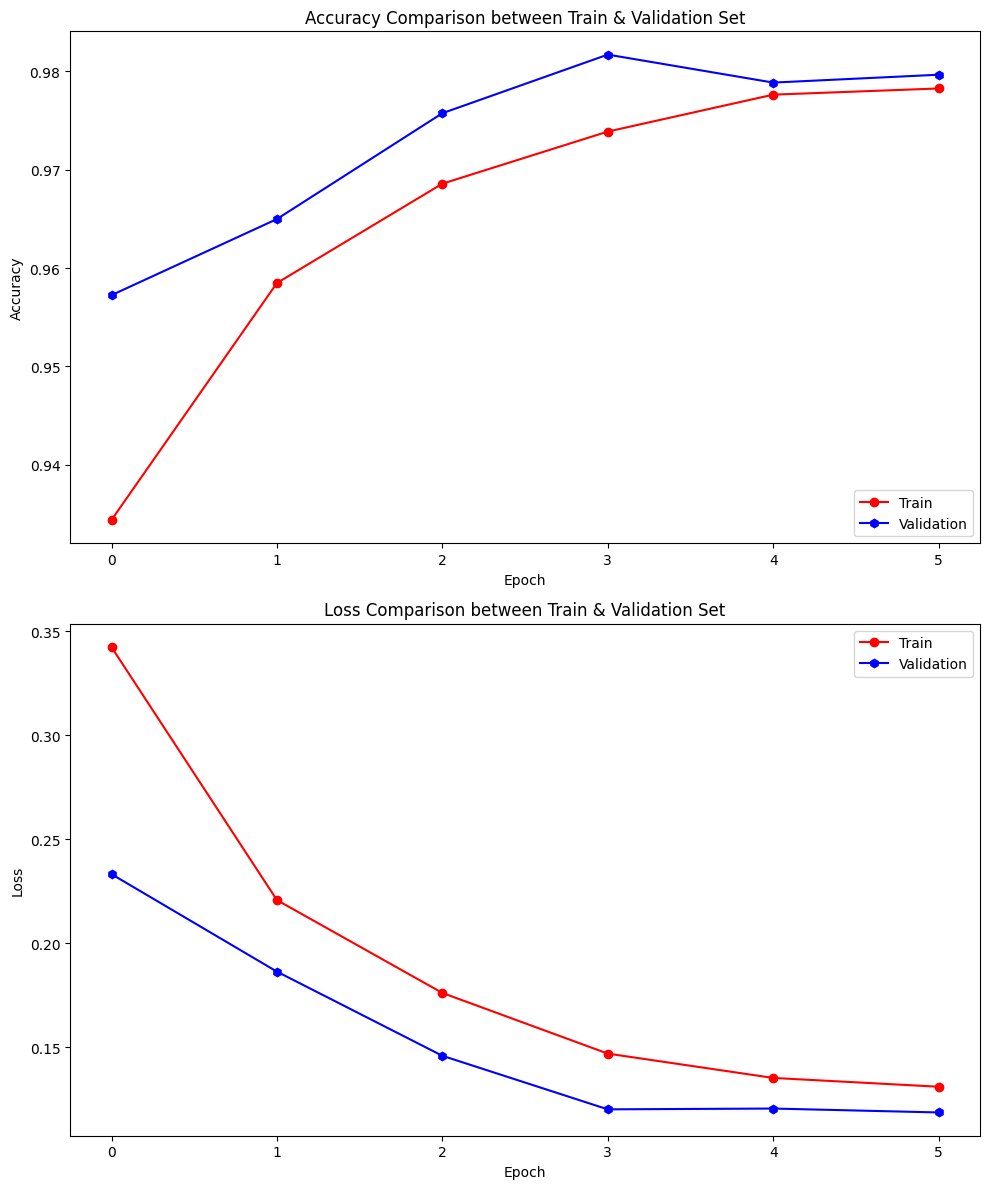

In [ ]:
plot_comparision_result(model_hist)

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      2250
         1.0       0.98      0.96      0.97      2250
         2.0       1.00      0.99      1.00      2250
         3.0       0.96      0.97      0.96      2250
         4.0       0.99      0.98      0.99      2250

    accuracy                           0.98     11250
   macro avg       0.98      0.98      0.98     11250
weighted avg       0.98      0.98      0.98     11250
 




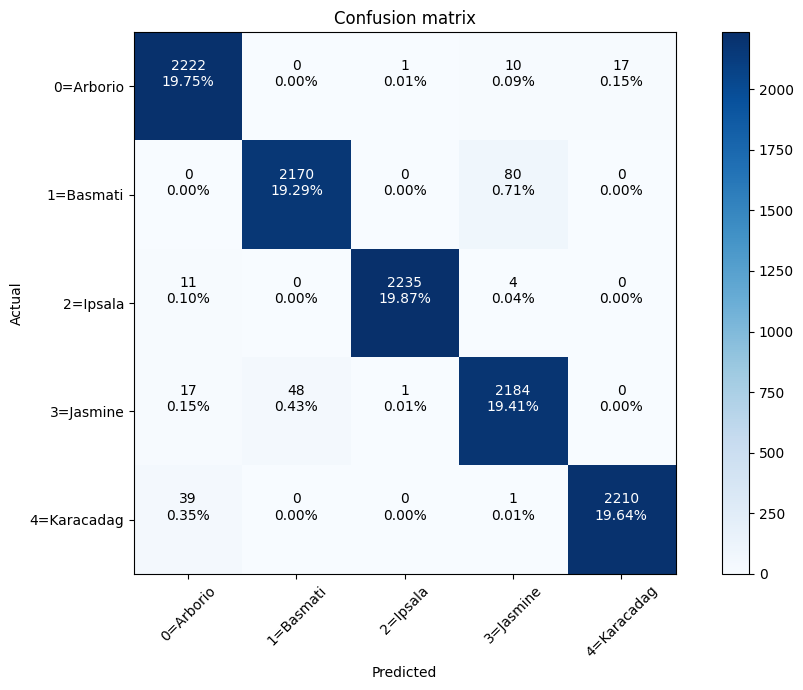

In [ ]:
y_true_val, y_pred_val = get_ture_and_pred_labels(Validation, model_5)

print(classification_report(y_true_val, y_pred_val), '\n\n')
cm = confusion_matrix(y_true_val, y_pred_val)

classes = {
    "Arborio":0,
    "Basmati":1,
    "Ipsala":2,
    "Jasmine":3,
    "Karacadag":4,
}

plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [ ]:
model_5.save('model_5')

# Test

In [ ]:
# Evaluate Finanl model and check it
test_loss, test_acc = model_5.evaluate(Test, verbose=2)
print(f'\nTest accuracy:{test_acc} (test_loss: {test_loss})')

704/704 - 65s - loss: 0.1124 - accuracy: 0.9804 - 65s/epoch - 92ms/step

Test accuracy:0.9803555607795715 (test_loss: 0.1124328002333641)


              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      2250
         1.0       0.98      0.96      0.97      2250
         2.0       1.00      1.00      1.00      2250
         3.0       0.96      0.97      0.96      2250
         4.0       0.99      0.98      0.99      2250

    accuracy                           0.98     11250
   macro avg       0.98      0.98      0.98     11250
weighted avg       0.98      0.98      0.98     11250
 




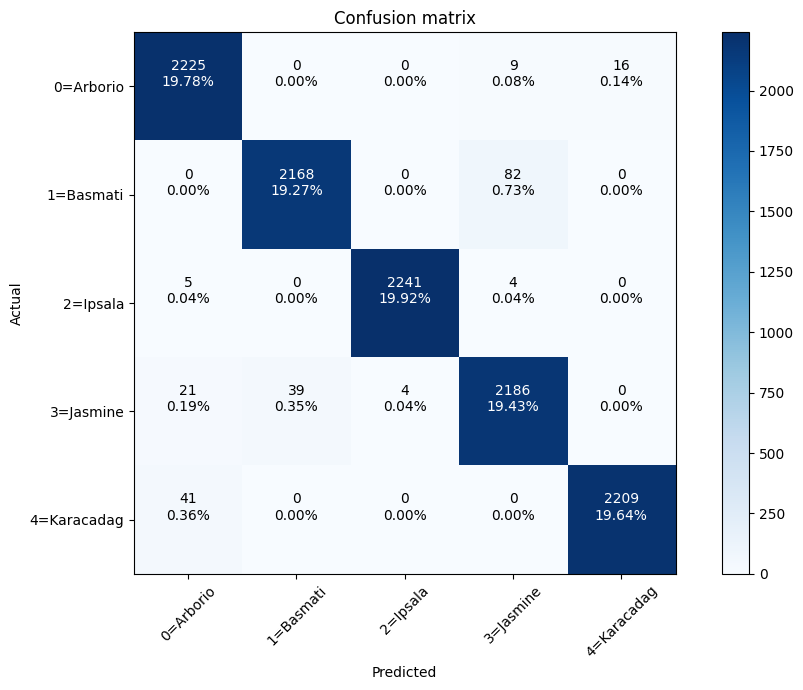

In [ ]:
y_true_test, y_pred_test = get_ture_and_pred_labels(Test, model_5)

print(classification_report(y_true_test, y_pred_test), '\n\n')
cm = confusion_matrix(y_true_test, y_pred_test)

classes = {
    "Arborio":0,
    "Basmati":1,
    "Ipsala":2,
    "Jasmine":3,
    "Karacadag":4,
}

plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)